In [1]:
import numpy as np

import pandas as pd
from collections import defaultdict
import string

import sklearn
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import word2vec
import xgboost as xgb
import matplotlib.pyplot as plt

# from keras.models import Sequential
# from keras.utils.np_utils import to_categorical
# from keras.layers import Dropout, Dense, Activation
# from keras.layers import BatchNormalization

from utils import preprocess
np.random.seed(1234)

In [2]:
df = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
text = df.text.values
text_test = df_test.text.values

author2class = {'EAP': 0, 'HPL' : 1, 'MWS' : 2}
class2author = ['EAP', 'HPL', 'MWS']
y = np.array([author2class[a] for a in df.author])

In [3]:
vec = word2vec.KeyedVectors.load_word2vec_format('./fastText/model.vec')

In [4]:
vec.most_similar(positive=['love'])

[('loved', 0.8400787115097046),
 ('lovelier', 0.8375217914581299),
 ('lover', 0.8341007828712463),
 ('loves', 0.8205721378326416),
 ('clove', 0.8196173906326294),
 ('loveliest', 0.8140965700149536),
 ("beloved's", 0.7933589220046997),
 ("lover's", 0.7773091197013855),
 ('jove', 0.7757792472839355),
 ('glove', 0.7705390453338623)]

In [5]:
vec.most_similar(positive=['the'])

[('theft', 0.8367539048194885),
 ("amalthea's", 0.8247981071472168),
 ('therefrom', 0.8049554824829102),
 ("'υπνος", 0.7993500232696533),
 ('cn', 0.7949093580245972),
 ('xiv', 0.7938920259475708),
 ('oxydracae', 0.786963701248169),
 ('cimabué', 0.7844108939170837),
 ('ottawa', 0.7829217910766602),
 ("azrael's", 0.7828168272972107)]

In [6]:
vec = word2vec.KeyedVectors.load_word2vec_format('./fastText/skip20_min2_neg15_epoch_7_ws_20.vec') # 0.527408070746
vec = word2vec.KeyedVectors.load_word2vec_format('./fastText/model.vec')

In [7]:
n = vec.vector_size
x = np.zeros((len(df), n))
for i, doc in enumerate(df.text):
    doc_vec = np.zeros(n)
    words = preprocess(doc).lower().split()
    num_words = 0
    for w in words:
        if w in vec.vocab:
            doc_vec += vec[w]
            num_words += 1
    doc_vec /= num_words
    x[i] = doc_vec

x_test = np.zeros((len(df_test), n))
for i, doc in enumerate(df_test.text):
    doc_vec = np.zeros(n)
    words = preprocess(doc).lower().split()
    num_words = 0
    for w in words:
        if w in vec.vocab:
            doc_vec += vec[w]
            num_words += 1
    doc_vec /= num_words
    x_test[i] = doc_vec


In [8]:
x.shape, y.shape, x_test.shape

((19579, 100), (19579,), (8392, 100))

In [9]:
num_split = 5
kf = KFold(n_splits=num_split, random_state=7, shuffle=True)
loss = 0.

predict_prob_features = np.zeros((len(df), 3))
predict_prob_features_test = np.zeros((len(df_test), 3))

for train_index, val_index in kf.split(x):
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = LogisticRegression()
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_val)
    predict_prob_features_test += model.predict_proba(x_test)
    predict_prob_features[val_index] = y_pred
    loss += log_loss(y_pred=y_pred, y_true=y_val)
        
print(loss/5)

0.521292042282


In [10]:
for a, c in author2class.items():
    df['{}_fasttext_logi'.format(a)] = predict_prob_features[:, c]
    df_test['{}_fasttext_logi'.format(a)] = predict_prob_features_test[:, c]/num_split

In [11]:
len(df)

19579

In [12]:
kf = KFold(n_splits=num_split, random_state=9, shuffle=True)
loss = 0.

predict_prob_features = np.zeros((len(df), 3))
predict_prob_features_test = np.zeros((len(df_test), 3))

for train_index, val_index in kf.split(text):
#     char_tfidf_vec = TfidfVectorizer(ngram_range=(1, 5), analyzer='char')
    char_tfidf_vec = TfidfVectorizer(ngram_range=(4, 5), analyzer='char')    
    print(len(train_index), len(val_index))
    text_train, text_val = text[train_index], text[val_index]
    y_train, y_val = y[train_index], y[val_index]

    x_train = char_tfidf_vec.fit_transform(text_train)
    x_val = char_tfidf_vec.transform(text_val)
    
    model = MultinomialNB()
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_val)

    predict_prob_features[val_index] = y_pred
    loss += log_loss(y_pred=y_pred, y_true=y_val)
    
    predict_prob_features_test += model.predict_proba(char_tfidf_vec.transform(text_test))
        
loss/5

15663 3916
15663 3916
15663 3916
15663 3916
15664 3915


0.60608730385491527

In [13]:
for a, c in author2class.items():
    df['{}_char_tfidf_NB'.format(a)] = predict_prob_features[:, c]
    df_test['{}_char_tfidf_NB'.format(a)] = predict_prob_features_test[:, c]/num_split

In [14]:
kf = KFold(n_splits=num_split, random_state=8, shuffle=True)
loss = 0.

predict_prob_features = np.zeros((len(df), 3))
predict_prob_features_test = np.zeros((len(df_test), 3))

for train_index, val_index in kf.split(text):
    word_tfidf_vec = TfidfVectorizer(ngram_range=(1, 3), analyzer='word')
#     word_tfidf_vec = TfidfVectorizer(ngram_range=(1, 3), analyzer='word')
    
    text_train, text_val = text[train_index], text[val_index]
    y_train, y_val = y[train_index], y[val_index]

    x_train = word_tfidf_vec.fit_transform(text_train)
    x_val = word_tfidf_vec.transform(text_val)
    
    model = MultinomialNB()
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_val)

    predict_prob_features[val_index] = y_pred
    loss += log_loss(y_pred=y_pred, y_true=y_val)
    
    predict_prob_features_test += model.predict_proba(word_tfidf_vec.transform(text_test))

loss/5

0.70510208764588955

In [15]:
for a, c in author2class.items():
    df['{}_word_tfidf_NB'.format(a)] = predict_prob_features[:, c]
    df_test['{}_word_tfidf_NB'.format(a)] = predict_prob_features_test[:, c]/num_split

In [16]:
kf = KFold(n_splits=num_split, random_state=8, shuffle=True)
loss = 0.

predict_prob_features = np.zeros((len(df), 3))
predict_prob_features_test = np.zeros((len(df_test), 3))

for train_index, val_index in kf.split(text):
#     word_tfidf_vec = TfidfVectorizer(ngram_range=(1, 2), analyzer='word')
    word_tfidf_vec = CountVectorizer(ngram_range=(1, 3), analyzer='word')
    
    text_train, text_val = text[train_index], text[val_index]
    y_train, y_val = y[train_index], y[val_index]

    x_train = word_tfidf_vec.fit_transform(text_train)
    x_val = word_tfidf_vec.transform(text_val)
    
    model = MultinomialNB()
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_val)

    predict_prob_features[val_index] = y_pred
    loss += log_loss(y_pred=y_pred, y_true=y_val)
    
    predict_prob_features_test += model.predict_proba(word_tfidf_vec.transform(text_test))

loss/5

0.80533791586116776

In [17]:
for a, c in author2class.items():
    df['{}_word_count_NB'.format(a)] = predict_prob_features[:, c]
    df_test['{}_word_count_NB'.format(a)] = predict_prob_features_test[:, c]/num_split

In [18]:
kf = KFold(n_splits=num_split, random_state=8, shuffle=True)
loss = 0.

predict_prob_features = np.zeros((len(df), 3))
predict_prob_features_test = np.zeros((len(df_test), 3))

for train_index, val_index in kf.split(text):
    word_tfidf_vec = CountVectorizer(ngram_range=(2, 5), analyzer='char')
    
    text_train, text_val = text[train_index], text[val_index]
    y_train, y_val = y[train_index], y[val_index]

    x_train = word_tfidf_vec.fit_transform(text_train)
    x_val = word_tfidf_vec.transform(text_val)
    
    model = MultinomialNB()
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_val)

    predict_prob_features[val_index] = y_pred
    loss += log_loss(y_pred=y_pred, y_true=y_val)
    
    predict_prob_features_test += model.predict_proba(word_tfidf_vec.transform(text_test))

loss/5

3.0823770695146928

In [19]:
for a, c in author2class.items():
    df['{}_char_count_NB'.format(a)] = predict_prob_features[:, c]
    df_test['{}_char_count_NB'.format(a)] = predict_prob_features_test[:, c]/num_split

In [20]:
# counter = {name : defaultdict(int) for name in set(df.author)}
# for (text, author) in zip(df.text, df.author):
#     text = text.replace(' ', '')
#     for c in text:
#         counter[author][c] += 1
    
# chars = set()
# for v in counter.values():
#     chars |= v.keys()
    
# names = [author for author in counter.keys()]
# special_latters = set()

# for c in chars:    
#     special_latters.add(c)
# special_latters = special_latters - 

In [21]:
normal_latters = set(string.ascii_uppercase) | set(string.ascii_lowercase) | set(',.:;"\'? ')

In [22]:
df['num_chars'] = np.array([len(t) for t in df.text])
df_test['num_chars'] = np.array([len(t) for t in df_test.text])

df['num_words'] = np.array([len(t.split()) for t in df.text])
df_test['num_words'] = np.array([len(t.split()) for t in df_test.text])

df['average_num_chars'] = np.array([np.mean([len(word) for word in t.split()]) for t in df.text])
df_test['average_num_chars'] = np.array([np.mean([len(word) for word in t.split()]) for t in df_test.text])

# for c in ',.:;"\'?':
for c in ',;':    
    df['num_'+c] = np.array([t.count(c) for t in df.text])
    df_test['num_'+c] = np.array([t.count(c) for t in df_test.text])


In [23]:
# num_special_chars = []
# for t in df.text:
#     prod = set(t) - normal_latters
#     c = 0
#     for p in prod:
#         c += t.count(p)
    
#     num_special_chars.append(c)

# df['num_special_chars'] = np.array(num_special_chars)

# num_special_chars = []
# for t in df_test.text:
#     prod = set(t) - normal_latters
#     c = 0
#     for p in prod:
#         c += t.count(p)
    
#     num_special_chars.append(c)

# df_test['num_special_chars'] = np.array(num_special_chars)


In [24]:
df.drop('id', axis=1, inplace=True)
df.drop('text', axis=1, inplace=True)
df.drop('author', axis=1, inplace=True)

In [25]:
# kf = model_selection.KFold(n_splits=num_split, shuffle=True, random_state=2017)
# xgb_model = xgb.XGBClassifier()

In [26]:
df.keys()

Index(['EAP_fasttext_logi', 'HPL_fasttext_logi', 'MWS_fasttext_logi',
       'EAP_char_tfidf_NB', 'HPL_char_tfidf_NB', 'MWS_char_tfidf_NB',
       'EAP_word_tfidf_NB', 'HPL_word_tfidf_NB', 'MWS_word_tfidf_NB',
       'EAP_word_count_NB', 'HPL_word_count_NB', 'MWS_word_count_NB',
       'EAP_char_count_NB', 'HPL_char_count_NB', 'MWS_char_count_NB',
       'num_chars', 'num_words', 'average_num_chars', 'num_,', 'num_;'],
      dtype='object')

In [27]:

# df.drop('EAP_fasttext_logi', axis=1, inplace=True)
# df.drop('HPL_fasttext_logi', axis=1, inplace=True)
# df.drop('MWS_fasttext_logi', axis=1, inplace=True)


In [28]:
df

,EAP_fasttext_logi,HPL_fasttext_logi,MWS_fasttext_logi,EAP_char_tfidf_NB,HPL_char_tfidf_NB,MWS_char_tfidf_NB,EAP_word_tfidf_NB,HPL_word_tfidf_NB,MWS_word_tfidf_NB,EAP_word_count_NB,HPL_word_count_NB,MWS_word_count_NB,EAP_char_count_NB,HPL_char_count_NB,MWS_char_count_NB,num_chars,num_words,average_num_chars,"num_,",num_;
0,0.837305,0.051619,0.111076,0.975090,0.005758,0.019152,0.852475,0.050684,0.096841,1.000000e+00,5.720684e-18,7.789074e-14,1.000000e+00,6.648805e-68,2.198842e-47,231,41,4.658537,4,2
1,0.649287,0.321049,0.029665,0.564762,0.258820,0.176418,0.631428,0.172834,0.195738,9.984968e-01,5.923958e-04,9.107964e-04,7.731037e-03,9.922690e-01,5.778141e-09,71,14,4.142857,0,0
2,0.765849,0.222766,0.011385,0.936623,0.049462,0.013915,0.727488,0.186471,0.086041,9.999998e-01,2.474739e-07,2.854591e-16,1.000000e+00,9.999448e-30,8.871767e-68,200,36,4.583333,4,0
3,0.005133,0.043287,0.951579,0.050458,0.047359,0.902182,0.250191,0.127471,0.622338,3.991464e-11,3.279028e-11,1.000000e+00,1.311047e-82,2.440619e-53,1.000000e+00,206,34,5.088235,3,0
4,0.324171,0.634930,0.040899,0.868431,0.059774,0.071794,0.544281,0.258319,0.197400,9.846133e-01,1.533806e-02,4.860644e-05,1.000000e+00,6.977833e-14,1.403324e-23,174,27,5.481481,2,1
5,0.207772,0.059838,0.732390,0.665842,0.004428,0.329730,0.558385,0.053802,0.387813,6.209473e-04,3.298060e-24,9.993791e-01,2.573601e-42,1.822710e-120,1.000000e+00,468,83,4.650602,4,0
6,0.947261,0.039617,0.013122,0.936866,0.038173,0.024961,0.665961,0.179944,0.154096,9.999948e-01,5.149104e-06,8.541582e-08,1.000000e+00,1.913401e-29,1.392536e-52,128,21,5.142857,3,1
7,0.928303,0.045297,0.026399,0.661767,0.169618,0.168616,0.602852,0.185493,0.211655,9.980715e-01,1.054154e-03,8.743531e-04,9.999998e-01,1.597773e-07,7.772336e-13,43,8,4.500000,0,0
8,0.587181,0.235327,0.177493,0.915953,0.014523,0.069524,0.808721,0.063959,0.127320,1.000000e+00,1.307445e-25,5.125262e-20,1.000000e+00,5.435917e-66,9.702550e-59,488,88,4.556818,7,1
9,0.255261,0.274112,0.470627,0.529576,0.065842,0.404582,0.425727,0.207912,0.366361,1.710407e-01,3.237142e-03,8.257221e-01,4.330545e-07,7.049098e-21,9.999996e-01,144,23,5.304348,2,0


In [29]:
df_test.drop('id', axis=1, inplace=True)
df_test.drop('text', axis=1, inplace=True)


In [30]:
param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.1 #01
param['max_depth'] = 3
param['silent'] = 1
param['num_class'] = 3
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 1
param['subsample'] = 0.8
param['colsample_bytree'] = 0.3
param['seed'] = 7
num_rounds = 6000

cv_scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=2017)
results = np.zeros((len(df_test), 3))
for train_ids, val_ids in kf.split(df):
    x_train, x_val = df.loc[train_ids], df.loc[val_ids]
    y_train, y_val = y[train_ids], y[val_ids]
    print(len(x_train), len(x_val))
    
    plst = list(param.items())
    xgtrain = xgb.DMatrix(x_train, label=y_train)
    xgtest = xgb.DMatrix(x_val, label=y_val)
    
    watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
    model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=170, verbose_eval=50)
    

    xgtest2 = xgb.DMatrix(df_test)
    results += model.predict(xgtest2, ntree_limit=model.best_ntree_limit)


15663 3916
[0]	train-mlogloss:1.00988	test-mlogloss:1.0095
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 170 rounds.
[50]	train-mlogloss:0.34485	test-mlogloss:0.349244
[100]	train-mlogloss:0.317949	test-mlogloss:0.336087
[150]	train-mlogloss:0.30186	test-mlogloss:0.332284
[200]	train-mlogloss:0.288304	test-mlogloss:0.330381
[250]	train-mlogloss:0.276691	test-mlogloss:0.329435
[300]	train-mlogloss:0.265852	test-mlogloss:0.32902
[350]	train-mlogloss:0.255607	test-mlogloss:0.328928
[400]	train-mlogloss:0.246124	test-mlogloss:0.329196
[450]	train-mlogloss:0.237499	test-mlogloss:0.329489
Stopping. Best iteration:
[303]	train-mlogloss:0.26511	test-mlogloss:0.328741

15663 3916
[0]	train-mlogloss:1.00906	test-mlogloss:1.00938
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 170 rounds.
[50]	train-mlogloss:0.341

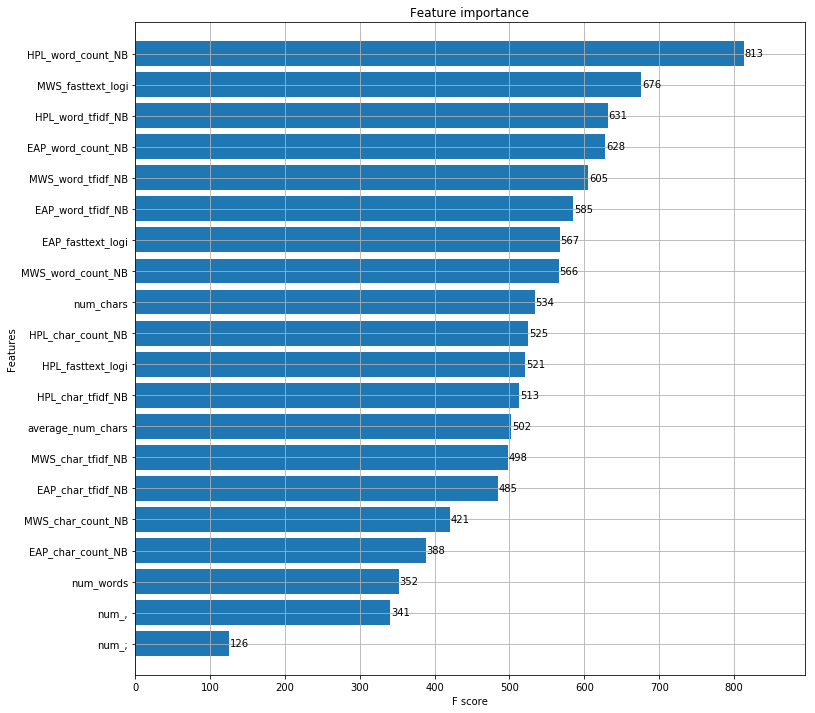

In [31]:
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [34]:
df = pd.read_csv('./data/sample_submission.csv')
for a, i in author2class.items():
    df[a] = results[:, i]

with open('./results/first_xgboost.csv', 'w') as f:
    f.write('"id","EAP","HPL","MWS"\n')
    for (index, row) in df.iterrows():
        f.write(','.join(['\"' + row['id'] + '\"'] +  list(map(str, [row['EAP'], row['HPL'], row['MWS']]))) + '\n')

array([[  6.71849977e-02,   1.22287003e-02,   4.92058641e+00],
       [  4.95765460e+00,   3.76400261e-02,   4.70536889e-03],
       [  2.14906840e-03,   4.99701107e+00,   8.39942499e-04],
       ..., 
       [  4.96144497e+00,   2.67624132e-02,   1.17927267e-02],
       [  3.55751149e-01,   2.02859659e-02,   4.62396294e+00],
       [  7.04471141e-01,   4.28443503e+00,   1.10937851e-02]])